In [1]:
! pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 22.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import librosa
import os
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import jiwer

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'speech_to_text_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "speech_to_text_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 51s 757ms/step - accuracy: 0.8646 - loss: 1.2762 - val_accuracy: 0.9417 - val_loss: 0.3179
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 79s 712ms/step - accuracy: 0.9429 - loss: 0.2970 - val_accuracy: 0.9426 - val_loss: 0.2676
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 40s 700ms/step - accuracy: 0.9464 - loss: 0.2490 - val_accuracy: 0.9491 - val_loss: 0.2086
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 43s 745ms/step - accuracy: 0.9526 - loss: 0.1896 - val_accuracy: 0.9596 - val_loss: 0.1464
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 38s 700ms/step - accuracy: 0.9679 - loss: 0.1273 - val_accuracy: 0.9840 - val_loss: 0.0902
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 39s 668ms/step - accuracy: 0.9906 - loss: 0.0763 - val_accuracy: 0.9978 - val_loss: 0.0563
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 44s 723ms/step - accuracy: 0.9984 - loss: 0.0493 - val_accuracy: 0.9993 - val_loss: 0.0386
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 38s 677ms/step - accuracy: 0.9996 - loss: 0.0347 - val_accu

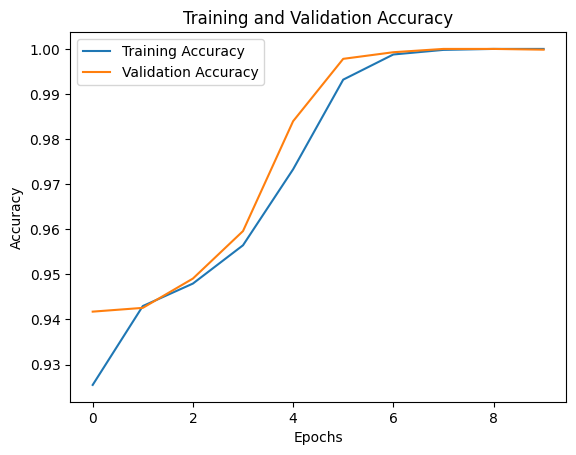

In [5]:
from google.colab import drive
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import librosa
import os
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import jiwer

# 1. Load Data
csv_file_path = '/content/drive/MyDrive/skripsi/50kalimat.csv'
audio_folder_path = '/content/drive/MyDrive/skripsi/dataAudio16Hz'

# Load the CSV and remove unnecessary columns
csv_data = pd.read_csv(csv_file_path)
csv_data = csv_data.drop(columns=['indo'])

# Menyusun data audio dan transkripsi
audio_files = []
transcriptions = []

for index, row in csv_data.iterrows():
    filename = row['filename']
    audio_file_path = os.path.join(audio_folder_path, f"{filename}.wav")
    if os.path.exists(audio_file_path):
        audio_files.append(audio_file_path)
        transcriptions.append(row['bugis'])

# Split the data into training, validation, and test sets
# 70% train, 15% validation, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(audio_files, transcriptions, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 2. Ekstraksi Fitur Audio (Mel-spectrogram)
def extract_audio_features(file_path, max_length=400):
    audio, sr = librosa.load(file_path, sr=None)
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=80, fmax=8000)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    # Padding atau memotong Mel spectrogram agar panjangnya konsisten
    if mel_spec.shape[1] < max_length:
        pad_width = max_length - mel_spec.shape[1]
        mel_spec = np.pad(mel_spec, ((0, 0), (0, pad_width)), mode='constant')
    elif mel_spec.shape[1] > max_length:
        mel_spec = mel_spec[:, :max_length]

    return mel_spec

# Ekstraksi fitur untuk data train, validation, dan test
X_train_features = [extract_audio_features(f) for f in X_train]
X_val_features = [extract_audio_features(f) for f in X_val]
X_test_features = [extract_audio_features(f) for f in X_test]

# 3. Tokenisasi Transkripsi
tokenizer = Tokenizer()
tokenizer.fit_on_texts(transcriptions)

y_train_tokenized = tokenizer.texts_to_sequences(y_train)
y_val_tokenized = tokenizer.texts_to_sequences(y_val)
y_test_tokenized = tokenizer.texts_to_sequences(y_test)

# Determine the target sequence length based on the model's output shape
target_sequence_length = X_train_features[0].shape[0]  # This is 80

# Padding untuk memastikan panjangnya seragam
y_train_tokenized = tf.keras.preprocessing.sequence.pad_sequences(y_train_tokenized, padding='post', maxlen=target_sequence_length)
y_val_tokenized = tf.keras.preprocessing.sequence.pad_sequences(y_val_tokenized, padding='post', maxlen=target_sequence_length)
y_test_tokenized = tf.keras.preprocessing.sequence.pad_sequences(y_test_tokenized, padding='post', maxlen=target_sequence_length)

# 4. Define the model
class SpeechToTextModel(Model):
    def __init__(self, vocab_size, input_shape):
        super(SpeechToTextModel, self).__init__()
        # Define the layers here without calling them
        self.lstm1 = layers.Bidirectional(layers.LSTM(128, return_sequences=True))
        self.lstm2 = layers.Bidirectional(layers.LSTM(128, return_sequences=True))
        self.dense = layers.Dense(vocab_size, activation='softmax')

    def call(self, inputs):
        # Pass the inputs through the layers in the call method
        x = self.lstm1(inputs)
        x = self.lstm2(x)
        return self.dense(x)

# Define vocab size based on your tokenizer
vocab_size = len(tokenizer.word_index) + 1  # plus one for padding

# Define the input shape (80 timesteps, 400 features)
input_shape = (80, 400)  # Example shape

# Initialize the model
model = SpeechToTextModel(vocab_size=vocab_size, input_shape=input_shape)

# Build the model with a dummy input shape to initialize its weights
model.build((None,) + input_shape)  # Add None for batch size

# Print model summary
model.summary()

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 5. Train the model
history = model.fit(np.array(X_train_features), np.expand_dims(y_train_tokenized, -1),
                    epochs=10, batch_size=32,
                    validation_data=(np.array(X_val_features), np.expand_dims(y_val_tokenized, -1)))

# 6. Plotting Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [6]:
# 8. Inferensi Sederhana: Prediksi Teks dari Audio
def predict_audio_to_text(model, audio_file, tokenizer):
    feature = extract_audio_features(audio_file)
    feature = np.expand_dims(feature, axis=0)  # batch dimension

    pred = model.predict(feature)
    # The model outputs a sequence of length 80, so we need to decode this sequence
    pred = np.argmax(pred, axis=-1)

    # Decode the prediction to text
    pred_text_list = []
    for seq in pred:
        decoded_seq = [tokenizer.index_word.get(idx, '') for idx in seq if idx != 0]  # Mengabaikan token padding
        pred_text_list.append(' '.join(decoded_seq))  # Gabungkan kata-kata menjadi satu kalimat

    return pred_text_list[0]

In [8]:
# Menentukan path file audio yang ingin diuji
audio_file_path = '/content/drive/MyDrive/skripsi/dataAudio16Hz/25_copy_1.wav'  # Ganti dengan path file audio yang sebenarnya

# Menggunakan fungsi untuk melakukan prediksi
predicted_text = predict_audio_to_text(model, audio_file_path, tokenizer)

# Menampilkan hasil prediksi
print(f"Predicted text: {predicted_text}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
Predicted text: maelo ko jokka sibawa wika


In [9]:
# 9. Inferensi untuk 10 Audio Acak
def predict_multiple_audio_to_text(model, audio_files, actual_texts, tokenizer, num_samples=10):
    random_indices = random.sample(range(len(audio_files)), num_samples)

    predicted_texts = []
    actual_texts_subset = []

    for idx in random_indices:
        audio_file = audio_files[idx]
        actual_text = actual_texts[idx]
        predicted_text = predict_audio_to_text(model, audio_file, tokenizer)
        predicted_texts.append(predicted_text)
        actual_texts_subset.append(actual_text)

    for i in range(num_samples):
        print(f"Audio {i + 1}:")
        print(f"Predicted text: {predicted_texts[i]}")
        print(f"Actual text: {actual_texts_subset[i]}")
        print("-" * 50)
# Uji Inferensi dengan 10 audio acak dari data validasi
predict_multiple_audio_to_text(model, X_val, y_val, tokenizer, num_samples=10)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Audio 1:
Predicted text: maelo ko jokka sibawa wika
Actual text: maelo ko jokka sibawa Wika
--------------------------------------------------
Audio 2:
Predicted text: mannasu kaju ki ga
Actual text: mannasu kaju ki ga?
--------------------------------------------------
Audio 3:
Predicted text: egana tu agagang mu ta'tale
Actual text: egana tu agagang mu ta'tale
--------------------------------------------------
Audio 4:
Predicted text: melli ka sulara wenni akki juppandang
Actual text: melli ka sulara wenni akki juppandang
--------------------------------------------------
Audio 5:
Predicted text: esso

In [10]:
# 7. Evaluate the Model using WER
def calculate_wer(predicted, actual):
    return jiwer.wer(actual, predicted)

# Evaluate WER for test data
predictions = [predict_audio_to_text(model, file, tokenizer) for file in X_test]
wer_scores = [calculate_wer(pred, true) for pred, true in zip(predictions, y_test)]
print(f"WER: {np.mean(wer_scores)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s